# Data Preparation for 2D Medical Imaging

## Kidney Segmentation with PyTorch Lightning and OpenVINO™ - Part 1

This tutorial is part of a series on how to train, optimize, quantize and show live inference on a medical segmentation model. The goal is to accelerate inference on a kidney segmentation model. The [UNet](https://arxiv.org/abs/1505.04597) model is trained from scratch; the data is from [KiTS19](https://github.com/neheller/kits19).

 The KiTS19 Nifty images are 3D files. Kidney segmentation is a relatively simple case for neural networks - it is expected that a 2D neural network should work quite well. 2D networks are smaller, and easier to work with than 3D networks, and image data is easier to work with than Nifty files. 

This first tutorial in the series shows how to:
 
- load Nifty images and get the data as array,
- apply windowing to a CT scan to increase contrast,
- convert Nifty data to 8-bit images.

> Note: This will not result in the best kidney segmentation model. Optimizing the kidney segmentation model is outside the scope of this tutorial. The goal is to have a small model that works reasonably well, as a starting point.


All notebooks in this series:

- Data Preparation for 2D Segmentation of 3D Medical Data (this notebook)
- [Train a 2D-UNet Medical Imaging Model with PyTorch Lightning](pytorch-monai-training.ipynb)
- [Convert and Quantize a UNet Model and Show Live Inference](110-ct-segmentation-quantize-nncf.ipynb)
- [Live Inference and Benchmark CT-scan data](110-ct-scan-live-inference.ipynb) 


## Instructions

To install the requirements for running this notebook, follow the instructions in the [`README.md` file](README.md). 

Before running this notebook, you must download the dataset from [KiTS19](https://github.com/neheller/kits19) with the code below. First, clone the repository and install the requirements. It is recommended to install the requirements in the `openvino_env` virtual environment.

```
   git clone https://github.com/neheller/kits19
   cd kits19
   pip install -r requirements.txt
   python -m starter_code.get_imaging
```

**The code above will take a long time to run. The downloaded content takes up around 21GB of data, and the converted images around 3.5GB**. Downloading the full dataset is only required if you want to train the model yourself. To show quantization on a downloadable subset of the dataset, see the [Convert and Quantize a UNet Model and Show Live Inference](110-ct-segmentation-quantize-nncf.ipynb) tutorial.



#### Table of content:- [Imports](#Imports-Uparrow)
- [Settings](#Settings-Uparrow)
- [Show One CT-scan](#Show-One-CT-scan-Uparrow)
- [Apply Window-Level to Increase Contrast](#Apply-Window-Level-to-Increase-Contrast-Uparrow)
- [Extract Slices from Nifty Data](#Extract-Slices-from-Nifty-Data-Uparrow)
- [References](#References-Uparrow)


## Imports [$\Uparrow$](#Table-of-content:)


In [32]:
import os
import time
from pathlib import Path
from typing import Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

## Settings [$\Uparrow$](#Table-of-content:)

Set `NIFTI_PATH` to the root directory of the Nifty files. This is the directory that contains the `case_00000` to `case_00299` subdirectories that contain `.nii.gz` data. The `FRAMES_DIR` variable should point to the directory to save the frames.

In [33]:
# Adjust the NIFTI_PATH to a directory that contains the case_00000 to case_00299 files with .nii.gz data.
NIFTI_PATH = Path("~/kits19/data").expanduser()
# The path to store the extracted frames. By default, this is the kits19_frames folder
# at the same level as the data folder in the kits19 root directory.
FRAMES_DIR = NIFTI_PATH.with_name("kits19_frames")
print(f"Kits19 frames will be saved to {FRAMES_DIR}")
# Checks if the NIFTI_PATH directory exists and contains the Nifty files.
assert NIFTI_PATH.exists(), f"NIFTI_PATH {NIFTI_PATH} does not exist"
assert len(list(NIFTI_PATH.glob("**/*nii.gz"))) > 0

Kits19 frames will be saved to C:\Users\amokrov\PycharmProjects\default\kits19\kits19_frames


## Show One CT-scan [$\Uparrow$](#Table-of-content:)

Load one CT-scan and visualize the scan and the label.

In [34]:
mask_path = NIFTI_PATH / "case_00002/segmentation.nii.gz"
image_path = mask_path.with_name("imaging.nii.gz")
nii_mask = nib.load(mask_path)
nii_image = nib.load(image_path)

mask_data = nii_mask.get_fdata()
image_data = nii_image.get_fdata()

# The nii_mask and nii_image are large objects and are no longer required.
del nii_mask
del nii_image
print(image_data.shape)

(261, 512, 512)


A CT-scan is a 3D image. To visualize it in 2D, create slices or frames. This can be done in three [anatomical planes](https://en.wikipedia.org/wiki/Anatomical_plane): from the front (coronal) , from the side (sagittal), or from the top (axial).

Since a kidney is relatively small, most pixels do not contain kidney data. For an indication, check the fraction of pixels that contain kidney data by dividing the number of non-zero pixels by the total number of pixels in the scan. 

In [35]:
np.count_nonzero(mask_data) / np.size(mask_data)

0.009557599765587585

This number shows that in this particular scan, less than one percent of all pixels in the scan belongs to a kidney. 

To find the frames with pixels that are annotated as kidney, and show the kidney from all three sides, use the code below:

In [36]:
z = np.argmax([np.count_nonzero(item) for item in mask_data])
x = np.argmax([np.count_nonzero(item) for item in np.transpose(mask_data, (1, 2, 0))])
y = np.argmax([np.count_nonzero(item) for item in np.transpose(mask_data, (2, 1, 0))])
print(z, x, y)

135 375 161


In [37]:
def show_slices(z: int, x: int, y: int):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    ax[0, 0].imshow(image_data[z], cmap="gray")
    ax[1, 0].imshow(mask_data[z], cmap="gray", vmin=0, vmax=2)
    ax[0, 1].imshow(image_data[:, x, :], cmap="gray")
    ax[1, 1].imshow(mask_data[:, x, :], cmap="gray", vmin=0, vmax=2)
    ax[0, 2].imshow(image_data[:, :, y], cmap="gray")
    ax[1, 2].imshow(mask_data[:, :, y], cmap="gray", vmin=0, vmax=2);

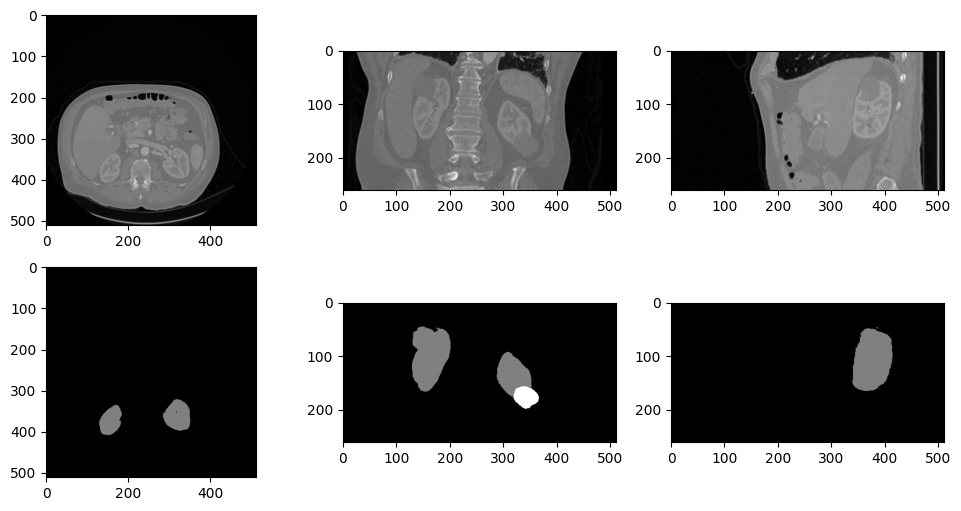

In [38]:
show_slices(z, x, y)

The image above shows three slices, from three different perspectives, in different places in the body. The middle slices shows two colors that indicate a kidney and a tumor, which are annotated in this slice.

## Apply Window-Level to Increase Contrast [$\Uparrow$](#Table-of-content:)

A CT-scan data can contain a large range of pixel values. This means that the contrast in the slices shown above is low. While histograms are used to visualize the distribution of the pixel values, a soft tissue window level is applied to increase the contrast for soft tissue in the visualization. For more information on windowing a CT-scan data, see the [Radiopaedia](https://radiopaedia.org/articles/windowing-ct).

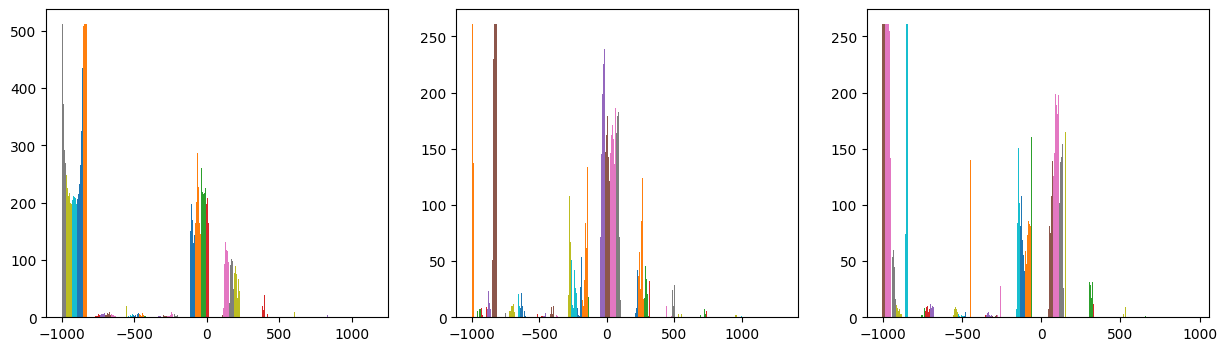

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axs[0].hist(image_data[z, ::])
axs[1].hist(image_data[:, x, :])
axs[2].hist(image_data[:, :, y]);

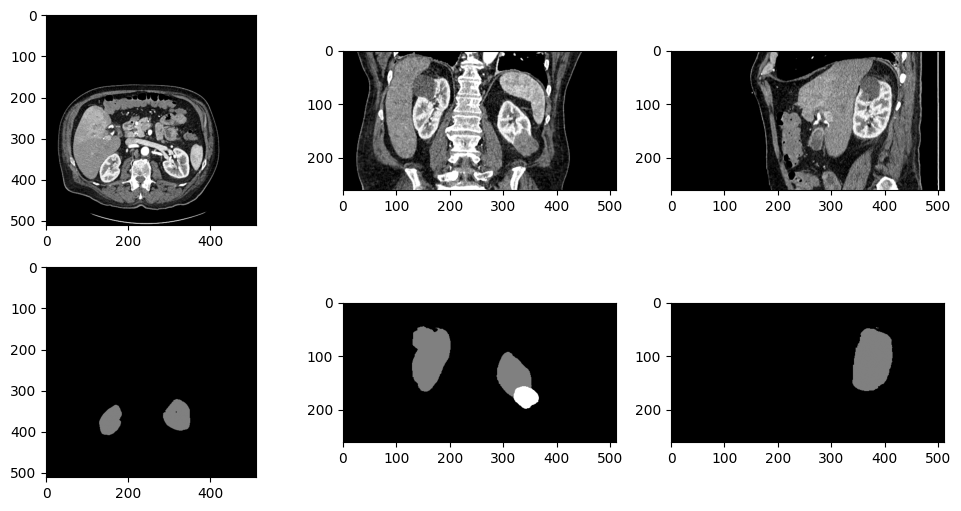

In [40]:
# (-125,225) is a suitable level for visualizing soft tissue
window_start = -125
window_end = 225
image_data[image_data < window_start] = window_start
image_data[image_data > window_end] = window_end
show_slices(z, x, y)

## Extract Slices from Nifty Data [$\Uparrow$](#Table-of-content:)

The `save_kits19_frames` function has `mask_path` of one `nii.gz` segmentation mask as argument, and converts the mask and corresponding image to a series of images that are saved as `.jpg` (for images) and `.png` (for masks) files.

In [41]:
def save_kits19_frames(
    mask_path: Path,
    root_dir: os.PathLike,
    window_level: Optional[Tuple] = None,
    make_binary: bool = True,
):
    """
    Save KiTS19 CT-scans to image files, optionally applying a window level.
    Images and masks are saved in a subdirectory of root_dir: case_XXXXX.
    Images are saved in imaging_frames, masks in segmentation frames, which are
    both subdirectories of the case directory.
    Frames are taken in the axial direction.

    :param mask_path: Path to segmentation.nii.gz file. The corresponding imaging.nii.gz
                      file should be in the same directory.
    :param root_dir: Root directory to save the generated image files. Will be generated
                     if it does not exist
    :param window_level: Window level top apply to the data before saving
    :param make_binary: If true, create a binary mask where all non-zero pixels are
                        considered to be "foreground" pixels and get pixel value 1.
    """
    start_time = time.time()

    Path(root_dir).mkdir(exist_ok=True)
    image_path = mask_path.with_name("imaging.nii.gz")

    assert mask_path.exists(), f"mask_path {mask_path} does not exist!"
    assert image_path.exists(), f"image_path {image_path} does not exist!"

    nii_mask = nib.load(mask_path)
    nii_image = nib.load(image_path)

    mask_data = nii_mask.get_fdata()
    image_data = nii_image.get_fdata()
    assert (
        mask_data.shape == image_data.shape
    ), f"Mask and image shape of {mask_path} are not equal"

    del nii_mask
    del nii_image

    if make_binary:
        mask_data[mask_data > 0] = 1

    if window_level is not None:
        window_start, window_end = window_level
        image_data[image_data < window_start] = window_start
        image_data[image_data > window_end] = window_end

    image_directory = Path(root_dir) / mask_path.parent.name / "imaging_frames"
    mask_directory = Path(root_dir) / mask_path.parent.name / "segmentation_frames"
    image_directory.parent.mkdir(exist_ok=True)
    image_directory.mkdir(exist_ok=True)
    mask_directory.mkdir(exist_ok=True)

    for i, (mask_frame, image_frame) in enumerate(zip(mask_data, image_data)):
        image_frame = (image_frame - image_frame.min()) / (
            image_frame.max() - image_frame.min()
        )
        image_frame = image_frame * 255
        image_frame = image_frame.astype(np.uint8)

        new_image_path = str(image_directory / f"{mask_path.parent.name}_{i:04d}.jpg")
        new_mask_path = str(mask_directory / f"{mask_path.parent.name}_{i:04d}.png")
        cv2.imwrite(new_image_path, image_frame)
        cv2.imwrite(new_mask_path, mask_frame)

    end_time = time.time()
    print(
        f"Saved {mask_path.parent.name} with {mask_data.shape[0]} frames "
        f"in {end_time-start_time:.2f} seconds"
    )

Run the code below to convert all Nifty files in `NIFTI_PATH` to images that are saved in `FRAMES_DIR`. A soft tissue window level of `(-125,225)` is applied and the segmentation labels are converted to binary kidney segmentations.

> Note: Running the following code will take quite a long time.

In [42]:
mask_paths = sorted(NIFTI_PATH.glob("case_*/segmentation.nii.gz"))

for mask_path in mask_paths:
    save_kits19_frames(
        mask_path=mask_path,
        root_dir=FRAMES_DIR,
        window_level=(-125, 225),
        make_binary=True,
    )

Saved case_00000 with 611 frames in 26.88 seconds
Saved case_00001 with 602 frames in 24.44 seconds
Saved case_00002 with 261 frames in 9.06 seconds
Saved case_00003 with 270 frames in 9.53 seconds
Saved case_00004 with 64 frames in 2.37 seconds
Saved case_00005 with 834 frames in 37.47 seconds
Saved case_00006 with 157 frames in 5.48 seconds
Saved case_00007 with 61 frames in 2.01 seconds
Saved case_00008 with 227 frames in 8.32 seconds
Saved case_00009 with 77 frames in 2.85 seconds
Saved case_00010 with 50 frames in 1.76 seconds
Saved case_00011 with 80 frames in 3.08 seconds
Saved case_00012 with 89 frames in 3.09 seconds
Saved case_00013 with 92 frames in 3.31 seconds
Saved case_00014 with 439 frames in 17.16 seconds
Saved case_00015 with 75 frames in 2.83 seconds
Saved case_00016 with 178 frames in 6.29 seconds
Saved case_00017 with 97 frames in 3.41 seconds
Saved case_00018 with 121 frames in 4.43 seconds
Saved case_00019 with 129 frames in 4.62 seconds
Saved case_00020 with 96 

## References [$\Uparrow$](#Table-of-content:)

- [KiTS19 Challenge Homepage](https://kits19.grand-challenge.org/)
- [KiTS19 GitHub Repository](https://github.com/neheller/kits19)
- [The KiTS19 Challenge Data: 300 Kidney Tumor Cases with Clinical Context, CT Semantic Segmentations, and Surgical Outcomes](https://arxiv.org/abs/1904.00445)
- [The state of the art in kidney and kidney tumor segmentation in contrast-enhanced CT imaging: Results of the KiTS19 challenge](https://www.sciencedirect.com/science/article/pii/S1361841520301857)
